In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import glob
from tabulate import tabulate
from tqdm import tqdm

In [3]:
import matplotlib.dates as dates
from scipy import stats
import pingouin as pg
import math
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
from scipy.signal import chirp, find_peaks, peak_widths
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from statistics import mode

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
import matplotlib.pyplot as plt
font = {'family': 'sans-serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [6]:
label_fontsize = 16 
title_fontsize = 18

In [7]:
basefolderdir = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
microbehepochspath = basefolderdir + "drosSleepStages_SciAdvances2023/data/beh_data/antenna_probbeh/"

In [8]:
outputfolderpath = basefolderdir + "SleepOnset_Drosophila/Scripts/pics/stats_grouplevel/"
outputfolderpath

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/SleepOnset_Drosophila/Scripts/pics/stats_grouplevel/'

In [9]:
def extractprobepochs(filename):
    
    probepochscsvinputpath = microbehepochspath + '/' + filename
    probepochs_df = pd.read_csv(probepochscsvinputpath)
       
    probepochs_df.columns = ['flyname','epoch', '+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1',
                                              '+0:+1_dur', '+1:+2_dur', 'midsleep_dur', 'x:-2_dur', 'x:-1_dur']
    
    probepochs_df = probepochs_df[['flyname', 'epoch',
                                       '+0:+1','+1:+2','midsleep',
                                       'x:-2','x:-1']]
    
    probepochs_df['total'] = probepochs_df['+0:+1'] + probepochs_df['+1:+2'] +\
                               probepochs_df['midsleep'] + probepochs_df['x:-2'] +\
                               probepochs_df['x:-1']
    
    probepochs_df['+0:+1'] =  probepochs_df['+0:+1'] / probepochs_df['total']
    probepochs_df['+1:+2'] =  probepochs_df['+1:+2'] / probepochs_df['total']
    probepochs_df['midsleep'] =  probepochs_df['midsleep'] / probepochs_df['total']
    probepochs_df['x:-2'] = probepochs_df['x:-2'] / probepochs_df['total']
    probepochs_df['x:-1'] =  probepochs_df['x:-1'] / probepochs_df['total']
    
    probepochs_df = probepochs_df.iloc[:, :-1]
    
    statsprobstats_df = probepochs_df.melt(id_vars=["flyname", "epoch"], var_name="epochtype",
                                              value_name="probcnt")
    
    return statsprobstats_df

In [10]:
def extractantennaepochs(filename):
    
    antennaepochscsvinputpath = microbehepochspath + '/' + filename
    antennapochs_df = pd.read_csv(antennaepochscsvinputpath)

    antennapochs_df.columns = ['flyname','epoch', '+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1',
                                              '+0:+1_dur', '+1:+2_dur', 'midsleep_dur', 'x:-2_dur', 'x:-1_dur']
    
    antennapochs_df = antennapochs_df[['flyname', 'epoch',
                                       '+0:+1','+1:+2','midsleep',
                                       'x:-2','x:-1']]

    antennapochs_df['total'] = antennapochs_df['+0:+1'] + antennapochs_df['+1:+2'] +\
                               antennapochs_df['midsleep'] + antennapochs_df['x:-2'] +\
                               antennapochs_df['x:-1']

    antennapochs_df['+0:+1'] =  antennapochs_df['+0:+1'] / antennapochs_df['total']
    antennapochs_df['+1:+2'] =  antennapochs_df['+1:+2'] / antennapochs_df['total']
    antennapochs_df['midsleep'] =  antennapochs_df['midsleep'] / antennapochs_df['total']
    antennapochs_df['x:-2'] = antennapochs_df['x:-2'] / antennapochs_df['total']
    antennapochs_df['x:-1'] =  antennapochs_df['x:-1'] / antennapochs_df['total']
    
    antennapochs_df = antennapochs_df.iloc[:, :-1]
    
    statsantennstats_df = antennapochs_df.melt(id_vars=["flyname", "epoch"], var_name="epochtype",
                                              value_name="antennacnt")
    
    return statsantennstats_df

In [11]:
def extractactivityperzeit(filename):
    
    stateepochscsvinputpath = microbehepochspath + '/' + filename
    df_epochs = pd.read_csv(stateepochscsvinputpath, index_col = 0)
    df_epochs = df_epochs.reset_index()

    df_epochs['start'] = pd.to_datetime(df_epochs['start'], format='%H:%M:%S')
    df_epochs['end'] = pd.to_datetime(df_epochs['end'], format='%H:%M:%S')
    df_epochs['duration'] = df_epochs['end'] - df_epochs['start']

    df_epochs['duration']=df_epochs['duration'].apply(lambda x: x + pd.Timedelta(days=1) if x < pd.Timedelta(0) else x)

    df_epochs['mins'] = df_epochs['duration'].dt.seconds/60
    df_epochs['zeit'] = None

    df_epochs.loc[(df_epochs['start'].dt.hour>=8) & (df_epochs['end'].dt.hour<20),'zeit'] = '08:to:20'
    df_epochs.loc[(df_epochs['start'].dt.hour>=20) | (df_epochs['end'].dt.hour<8),'zeit'] = '20:to:08'

    df_epochs = df_epochs.dropna()
    
    return df_epochs

In [12]:
def extractactivityperzeit2(filename):
    
    stateepochscsvinputpath = microbehepochspath + '/' + "fb_3.csv"
    df_epochs = pd.read_csv(stateepochscsvinputpath, index_col = 0)
    df_epochs = df_epochs.reset_index()
    
    df_epochs['start'] = pd.to_datetime(df_epochs['start'], format='%H:%M:%S')
    df_epochs['end'] = pd.to_datetime(df_epochs['end'], format='%H:%M:%S')
    df_epochs['duration'] = df_epochs['end'] - df_epochs['start']

    df_epochs['mins'] = df_epochs['duration'].dt.seconds/60
    
    
    return df_epochs

In [13]:
def parseactivityperzeit2(flyid, df_epochs):
    
    allactivitystats_df = df_epochs[(df_epochs.flyname == flyid)]
    
    tempstats_df = allactivitystats_df.sort_values("start").groupby("start").apply(lambda x: x.tail(1))
    
    tempstats_df["start2"] = pd.to_datetime(tempstats_df["start"])
    tempstats_df["end2"] = pd.to_datetime(tempstats_df["end"])
    tempstats_df["duration"] = abs(tempstats_df["end2"].shift(1) - tempstats_df["start2"])
    
    tempstats_df = tempstats_df.reset_index(drop=True)
    tempstats_df['pastidx'] = tempstats_df.index
    
    filtered_df = tempstats_df[tempstats_df["duration"] > pd.Timedelta(0)]
    sortfiltered_df = filtered_df.sort_values(by=['duration'], ascending=False)
    
    row = sortfiltered_df.iloc[0]
    
    tempstats2_df  = pd.concat([sortfiltered_df, tempstats_df.iloc[row.name + 1:], 
                            tempstats_df.iloc[:row.name]], ignore_index=True)

    tempstats2_df = tempstats2_df[['flyname', 'type', 'start', 'end']]
    
    
    # Convert the start and end columns to datetime objects
    tempstats2_df["start"] = pd.to_datetime(tempstats2_df["start"])
    tempstats2_df["end"] = pd.to_datetime(tempstats2_df["end"])


    tempstats2_df['is_same_day_start'] = tempstats2_df["start"]>=tempstats2_df.loc[0,"start"]
    tempstats2_df['is_same_day_end'] = tempstats2_df["end"]>tempstats2_df.loc[0,"start"]

    #add the roll-over stuff now
    tempstats2_df.loc[tempstats2_df['is_same_day_start'] == False, 'start'] =\
                    tempstats2_df.loc[tempstats2_df['is_same_day_start'] == False, 'start'] + pd.Timedelta(days=1)

    tempstats2_df.loc[tempstats2_df['is_same_day_end'] == False, 'end'] =\
                    tempstats2_df.loc[tempstats2_df['is_same_day_end'] == False, 'end'] + pd.Timedelta(days=1)
    
    tempstats2_df['duration'] = tempstats2_df['end'] - tempstats2_df['start']
    
    possissue_df = tempstats2_df[tempstats2_df['duration'] > timedelta(hours=7)]
    
    possissue_df = possissue_df[['flyname', 'type', 'start', 'end', 'duration']]
    
#     if possissue_df.empty == False:
#         print('\n')
#         print('really long epochs found')
#         print(possissue_df)
#         print('\n')
        
    zeitstart_time = tempstats2_df.iloc[0]["start"] - pd.Timedelta(hours=8)
    zeitend_time = tempstats2_df.iloc[-1]["end"] - pd.Timedelta(hours=8)
    
    # if tempstats2_df.iloc[0]["start"].hour >= 8:
    #     zeitstart_time = tempstats2_df.iloc[0]["start"] - pd.Timedelta(hours=8)
    # else:
    #     zeitstart_time = tempstats2_df.iloc[0]["start"] + pd.Timedelta(hours=16)
    
    # if tempstats2_df.iloc[-1]["end"].hour >= 8:
    #     zeitend_time = tempstats2_df.iloc[-1]["end"] - pd.Timedelta(hours=8)
    # else:
    #     zeitend_time = tempstats2_df.iloc[-1]["end"] + pd.Timedelta(hours=16)
    
    print("The start time is {}:{}:{}".format(tempstats2_df.iloc[0]["start"].hour,
                                          tempstats2_df.iloc[0]["start"].minute, 
                                          tempstats2_df.iloc[0]["start"].second))
    
    print("The end time is {}:{}:{}".format(tempstats2_df.iloc[-1]["end"].hour,
                                          tempstats2_df.iloc[-1]["end"].minute, 
                                          tempstats2_df.iloc[-1]["end"].second))
    
    
    print("The zeitgeber start time is {}:{}:{}".format(zeitstart_time.hour, zeitstart_time.minute, 
                                              zeitstart_time.second))
    
    print("The zeitgeber end time is {}:{}:{}".format(zeitend_time.hour, zeitend_time.minute, 
                                              zeitend_time.second))
    
    duration_time  = tempstats2_df.iloc[-1]["end"] - tempstats2_df.iloc[0]["start"]
    print("The duration is {}:{}:{}".format(duration_time.seconds // 3600,
                                            (duration_time.seconds %3600) // 60, 
                                            duration_time.seconds % 60))
    
    tempstats2_df = tempstats2_df[['flyname', 'type', 'start', 'end', 'duration']]
    
    tempstats2_df['zeit'] = None
    tempstats2_df.loc[(tempstats2_df['start'].dt.hour>=8) & (tempstats2_df['end'].dt.hour<20),'zeit'] = '08:to:20'
    tempstats2_df.loc[(tempstats2_df['start'].dt.hour>=20) | (tempstats2_df['end'].dt.hour<8),'zeit'] = '20:to:08'
    
    tempstats2_df = tempstats2_df.dropna()
    
    return tempstats2_df


In [14]:
df_epochs = extractactivityperzeit2("fb_3.csv")

In [15]:
allepochstats_df = pd.DataFrame(columns=['flyname', 'type', 'start', 'end', 'duration', 'zeit'])

In [16]:
for fly_id in df_epochs['flyname'].unique():
    print('\n\nProcessing fly id: ', fly_id)
    allepochstats_df = allepochstats_df.append(parseactivityperzeit2(fly_id, df_epochs))   



Processing fly id:  1
The start time is 18:17:56
The end time is 11:0:39
The zeitgeber start time is 10:17:56
The zeitgeber end time is 3:0:39
The duration is 16:42:43


Processing fly id:  2
The start time is 17:23:22
The end time is 7:23:21
The zeitgeber start time is 9:23:22
The zeitgeber end time is 23:23:21
The duration is 13:59:59


Processing fly id:  3
The start time is 17:59:18
The end time is 11:20:34
The zeitgeber start time is 9:59:18
The zeitgeber end time is 3:20:34
The duration is 17:21:16


Processing fly id:  4
The start time is 15:37:16
The end time is 9:37:16
The zeitgeber start time is 7:37:16
The zeitgeber end time is 1:37:16
The duration is 18:0:0


Processing fly id:  5
The start time is 17:31:37
The end time is 9:57:4
The zeitgeber start time is 9:31:37
The zeitgeber end time is 1:57:4
The duration is 16:25:27


Processing fly id:  6
The start time is 18:6:47
The end time is 9:2:0
The zeitgeber start time is 10:6:47
The zeitgeber end time is 1:2:0
The duration

In [17]:
allepochstats_df.head()

,flyname,type,start,end,duration,zeit
1,1,sleep,1900-01-01 21:58:13,1900-01-01 22:05:41,0 days 00:07:28,20:to:08
2,1,awake,1900-01-01 22:05:41,1900-01-01 22:27:03,0 days 00:21:22,20:to:08
3,1,sleep,1900-01-01 22:27:03,1900-01-01 22:37:07,0 days 00:10:04,20:to:08
4,1,awake,1900-01-01 22:37:07,1900-01-01 22:41:36,0 days 00:04:29,20:to:08
5,1,sleep,1900-01-01 22:41:36,1900-01-01 22:47:21,0 days 00:05:45,20:to:08


In [18]:
allepochstats_df['zeit'].value_counts()

20:to:08    360
08:to:20     83
Name: zeit, dtype: int64

In [19]:
leftantennstats_df = extractantennaepochs("leftAntNorm_2.csv")
leftantennstats_df["anttype"] = "left"

In [20]:
leftantennstats_df.head()

,flyname,epoch,epochtype,antennacnt,anttype
0,1,1,+0:+1,0.000000,left
1,1,2,+0:+1,0.530507,left
2,1,3,+0:+1,0.000000,left
3,1,4,+0:+1,0.430411,left
4,1,5,+0:+1,0.599448,left


In [21]:
rightantennstats_df = extractantennaepochs("rightAntNorm_2.csv")
rightantennstats_df["anttype"] = "right"

In [22]:
rightantennstats_df.head()

,flyname,epoch,epochtype,antennacnt,anttype
0,1,1,+0:+1,0.379956,right
1,1,2,+0:+1,0.257505,right
2,1,3,+0:+1,0.500252,right
3,1,4,+0:+1,0.293739,right
4,1,5,+0:+1,0.250207,right


In [23]:
allantennstats_df = pd.concat([leftantennstats_df,rightantennstats_df])

In [24]:
allprobstats_df = extractprobepochs("peLOCSFrac_3.csv")

In [25]:
allprobstats_df.head()

,flyname,epoch,epochtype,probcnt
0,1,1,+0:+1,1.000000
1,1,2,+0:+1,NaN
2,1,3,+0:+1,NaN
3,1,4,+0:+1,0.909982
4,1,5,+0:+1,NaN


In [26]:
%R -i allantennstats_df

In [27]:
%%R
head(allantennstats_df)

  flyname epoch epochtype antennacnt anttype
1       1     1     +0:+1  0.0000000    left
2       1     2     +0:+1  0.5305065    left
3       1     3     +0:+1  0.0000000    left
4       1     4     +0:+1  0.4304110    left
5       1     5     +0:+1  0.5994475    left
6       1     6     +0:+1  0.0000000    left


In [28]:
%%R
packageVersion("lme4")

[1] ‘1.1.21’


In [29]:
%%R
# Multilevel model with missing values ~ Hierarchical model
# First compare and choose the best model..

library(lmerTest)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [30]:
%%R
model.null = lmer(antennacnt ~ 1 + (1|flyname), 
                  data=allantennstats_df[allantennstats_df$anttype == "left", ],
                  REML=FALSE)

model.epochtype = lmer(antennacnt ~ epochtype + (1|flyname), 
                        data=allantennstats_df[allantennstats_df$anttype == "left", ],
                  REML=FALSE)

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



In [31]:
%%R
#compare the null model, with the epoch type model..
print(anova(model.null,model.epochtype))

Data: allantennstats_df[allantennstats_df$anttype == "left", ]
Models:
model.null: antennacnt ~ 1 + (1 | flyname)
model.epochtype: antennacnt ~ epochtype + (1 | flyname)
                Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null       3 219.06 234.05 -106.53   213.06                             
model.epochtype  7 161.16 196.12  -73.58   147.16 65.905      4  1.659e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [32]:
%%R
#the above analysis show that the epoch type model is the most likely model..
#let's analyse the same..
print(anova(model.epochtype))

Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF DenDF F value    Pr(>F)    
epochtype 4.5527  1.1382     4  1090  16.985 1.611e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [33]:
%%R
library("MuMIn")
r.squaredGLMM(model.epochtype)

            R2m        R2c
[1,] 0.05872216 0.05872216


In [34]:
%%R
#the above table shows that there is a main effect of epoch type, let's find out what 
#categories are actually different..

NULL


In [35]:
%%R
library("multcomp")
# Step 5: Post Hoc comparisions 
model = lmer(antennacnt ~ epochtype + (1|flyname), data=allantennstats_df[allantennstats_df$anttype == "left", ],
             REML=FALSE)

print(summary(glht(model, mcp(epochtype="Tukey"))))

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: TH.data

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘TH.data’


R[write to console]: The following object is masked from ‘package:MASS’:

    geyser


R[write to console]: boundary (singular) fit: see ?isSingular




	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = antennacnt ~ epochtype + (1 | flyname), data = allantennstats_df[allantennstats_df$anttype == 
    "left", ], REML = FALSE)

Linear Hypotheses:
                       Estimate Std. Error z value Pr(>|z|)    
+1:+2 - +0:+1 == 0    -0.025610   0.024795  -1.033    0.840    
midsleep - +0:+1 == 0  0.146951   0.024795   5.927   <1e-04 ***
x:-1 - +0:+1 == 0     -0.007426   0.024795  -0.300    0.998    
x:-2 - +0:+1 == 0     -0.019252   0.024795  -0.776    0.937    
midsleep - +1:+2 == 0  0.172561   0.024795   6.959   <1e-04 ***
x:-1 - +1:+2 == 0      0.018183   0.024795   0.733    0.949    
x:-2 - +1:+2 == 0      0.006357   0.024795   0.256    0.999    
x:-1 - midsleep == 0  -0.154378   0.024795  -6.226   <1e-04 ***
x:-2 - midsleep == 0  -0.166203   0.024795  -6.703   <1e-04 ***
x:-2 - x:-1 == 0      -0.011826   0.024795  -0.477    0.989    
---
Signif. codes:  0 ‘***’ 0.

In [36]:
%%R
model.null = lmer(antennacnt ~ 1 + (1|flyname), 
                  data=allantennstats_df[allantennstats_df$anttype == "right", ],
                  REML=FALSE)

model.epochtype = lmer(antennacnt ~ epochtype + (1|flyname), 
                        data=allantennstats_df[allantennstats_df$anttype == "right", ],
                  REML=FALSE)

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



In [37]:
%%R
#compare the null model, with the epoch type model..
print(anova(model.null,model.epochtype))

Data: allantennstats_df[allantennstats_df$anttype == "right", ]
Models:
model.null: antennacnt ~ 1 + (1 | flyname)
model.epochtype: antennacnt ~ epochtype + (1 | flyname)
                Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null       3 142.83 157.91 -68.415  136.830                             
model.epochtype  7 102.94 138.11 -44.468   88.935 47.894      4  9.929e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [38]:
%%R
#the above analysis show that the epoch type model is the most likely model..
#let's analyse the same..
print(anova(model.epochtype))

Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF DenDF F value    Pr(>F)    
epochtype 3.1004  0.7751     4  1125  12.232 9.729e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [39]:
%%R
library("MuMIn")
r.squaredGLMM(model.epochtype)

            R2m        R2c
[1,] 0.04171469 0.04171469


In [40]:
%%R
#the above table shows that there is a main effect of epoch type, let's find out what 
#categories are actually different..

NULL


In [41]:
%%R
library("multcomp")
# Step 5: Post Hoc comparisions 
model = lmer(antennacnt ~ epochtype + (1|flyname), data=allantennstats_df[allantennstats_df$anttype == "right", ],
             REML=FALSE)

print(summary(glht(model, mcp(epochtype="Tukey"))))

R[write to console]: boundary (singular) fit: see ?isSingular




	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = antennacnt ~ epochtype + (1 | flyname), data = allantennstats_df[allantennstats_df$anttype == 
    "right", ], REML = FALSE)

Linear Hypotheses:
                        Estimate Std. Error z value Pr(>|z|)    
+1:+2 - +0:+1 == 0     0.0241771  0.0237330   1.019    0.847    
midsleep - +0:+1 == 0  0.1417259  0.0237330   5.972   <1e-04 ***
x:-1 - +0:+1 == 0      0.0006699  0.0237330   0.028    1.000    
x:-2 - +0:+1 == 0      0.0341417  0.0237330   1.439    0.603    
midsleep - +1:+2 == 0  0.1175488  0.0237330   4.953   <1e-04 ***
x:-1 - +1:+2 == 0     -0.0235071  0.0237330  -0.990    0.860    
x:-2 - +1:+2 == 0      0.0099646  0.0237330   0.420    0.994    
x:-1 - midsleep == 0  -0.1410559  0.0237330  -5.943   <1e-04 ***
x:-2 - midsleep == 0  -0.1075842  0.0237330  -4.533   <1e-04 ***
x:-2 - x:-1 == 0       0.0334718  0.0237330   1.410    0.621    
---
Signif. codes:

In [42]:
color_dict = dict({'awake':'#B34D4D',
                    '-2:-1':'#F2AF0D','-1:+0':'#F2AF0D',
                   '+0:+1':'#1AC2E6','+1:+2':'#1AC2E6',
                   'midsleep':'#0D28F2',
                   'x:-2':'#B3704D','x:-1':'#B3704D',
                  })

In [43]:
plotleftantennastats_df = allantennstats_df[allantennstats_df["anttype"] == "left"]
plotleftantennastats_df = plotleftantennastats_df.groupby(['flyname', 'epochtype'])['antennacnt'].mean()
plotleftantennastats_df = plotleftantennastats_df.reset_index()

In [44]:
plotleftantennastats_df.head()

,flyname,epochtype,antennacnt
0,1,+0:+1,0.268671
1,1,+1:+2,0.170736
2,1,midsleep,0.305586
3,1,x:-1,0.186852
4,1,x:-2,0.068156


In [45]:
plotrightantennastats_df = allantennstats_df[allantennstats_df["anttype"] == "right"]
plotrightantennastats_df = plotrightantennastats_df.groupby(['flyname', 'epochtype'])['antennacnt'].mean()
plotrightantennastats_df = plotrightantennastats_df.reset_index()

In [46]:
plotrightantennastats_df.head()

,flyname,epochtype,antennacnt
0,1,+0:+1,0.220267
1,1,+1:+2,0.182344
2,1,midsleep,0.226149
3,1,x:-1,0.189634
4,1,x:-2,0.181606


In [47]:
np.unique(plotrightantennastats_df['epochtype'])

array(['+0:+1', '+1:+2', 'midsleep', 'x:-1', 'x:-2'], dtype=object)

In [48]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

In [49]:
def statannotation(ax, x1, x2, y,text, h = 2):
    text_offset = 0.5
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

Text(0.5, 1.0, 'right antenna')

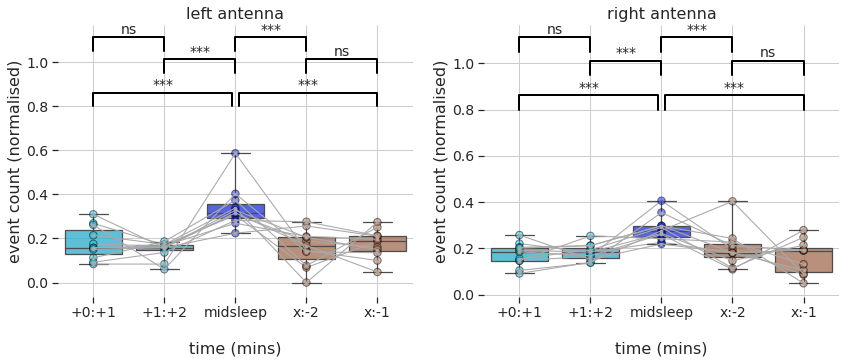

In [50]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7*2, 5))

sns.boxplot(x='epochtype', y='antennacnt', data=plotleftantennastats_df,  
            order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
            whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette=color_dict)

sns.stripplot(x='epochtype', y='antennacnt', data=plotleftantennastats_df,
              jitter=False, linewidth=1,ax=ax1,
              order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
              palette=color_dict,marker='o', s= 7.5, alpha = 0.5,edgecolor ="black")

ax1 = sns.pointplot(x='epochtype', y='antennacnt',hue='flyname',data=plotleftantennastats_df,
                    order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
                    ax=ax1, dodge=0.0,
                    palette=['darkgray'])

ax1.legend_.remove()
b = list(ax1.get_children())

string_val1 = 'ns'
string_val2 = '***'
statannotation(ax = ax1, x1 = 0, x2 = 1, y = 1.25-0.2, h = 0.125/2, text = string_val1)
statannotation(ax = ax1, x1 = 1, x2 = 2, y = 1.15-0.2, h = 0.125/2, text = string_val2)
statannotation(ax = ax1, x1 = 0, x2 = 1.95, y = 1.25-0.45, h = 0.125/2, text = string_val2)

statannotation(ax = ax1, x1 = 2, x2 = 3, y = 1.25-0.2, h = 0.125/2, text = string_val2)
statannotation(ax = ax1, x1 = 3, x2 = 4, y = 1.15-0.2, h = 0.125/2, text = string_val1)
statannotation(ax = ax1, x1 = 2.05, x2 = 4, y = 1.25-0.45, h = 0.125/2, text = string_val2)


for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
    
sns.despine(left=True, bottom = True)

ax1.set_ylabel('event count (normalised)', fontsize=label_fontsize)
ax1.set_xlabel('\ntime (mins)', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)
ax1.set_title('left antenna',fontsize=label_fontsize)


sns.boxplot(x='epochtype', y='antennacnt', data=plotrightantennastats_df,
            order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
            whis=np.inf, ax=ax2, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette=color_dict)

sns.stripplot(x='epochtype', y='antennacnt', data=plotrightantennastats_df,
              order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
              jitter=False, linewidth=1,ax=ax2,
              palette=color_dict,marker='o', s= 7.5, alpha = 0.5,edgecolor ="black")

ax2 = sns.pointplot(x='epochtype', y='antennacnt',hue='flyname',data=plotrightantennastats_df,
                    order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
                    ax=ax2, dodge=0.0,
                    palette=['darkgray'])

ax2.legend_.remove()
b = list(ax2.get_children())

string_val1 = 'ns'
string_val2 = '***'
statannotation(ax = ax2, x1 = 0, x2 = 1, y = 1.25-0.2, h = 0.125/2, text = string_val1)
statannotation(ax = ax2, x1 = 1, x2 = 2, y = 1.15-0.2, h = 0.125/2, text = string_val2)
statannotation(ax = ax2, x1 = 0, x2 = 1.95, y = 1.25-0.45, h = 0.125/2, text = string_val2)

statannotation(ax = ax2, x1 = 2, x2 = 3, y = 1.25-0.2, h = 0.125/2, text = string_val2)
statannotation(ax = ax2, x1 = 3, x2 = 4, y = 1.15-0.2, h = 0.125/2, text = string_val1)
statannotation(ax = ax2, x1 = 2.05, x2 = 4, y = 1.25-0.45, h = 0.125/2, text = string_val2)


for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
    
sns.despine(left=True, bottom = True)

ax2.set_ylabel('event count (normalised)', fontsize=label_fontsize)
ax2.set_xlabel('\ntime (mins)', fontsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax2.grid(True)
ax2.set_title('right antenna',fontsize=label_fontsize)


# plt.savefig(outputfolderpath + 'microbehaviors_antenna.svg', format='svg', dpi=240, transparent=False,
#             bbox_inches='tight')


In [51]:
%R -i allprobstats_df

In [52]:
%%R
head(allprobstats_df)

  flyname epoch epochtype   probcnt
0       1     1     +0:+1 1.0000000
1       1     2     +0:+1       NaN
2       1     3     +0:+1       NaN
3       1     4     +0:+1 0.9099817
4       1     5     +0:+1       NaN
5       1     6     +0:+1 0.0000000


In [53]:
%%R
model.null = lmer(probcnt ~ 1 + (1|flyname), 
                  data=allprobstats_df,
                  REML=FALSE)

model.epochtype = lmer(probcnt ~ epochtype + (1|flyname), 
                        data=allprobstats_df,
                  REML=FALSE)

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



In [54]:
%%R
#compare the null model, with the epoch type model..
print(anova(model.null,model.epochtype))

Data: allprobstats_df
Models:
model.null: probcnt ~ 1 + (1 | flyname)
model.epochtype: probcnt ~ epochtype + (1 | flyname)
                Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null       3 608.19 622.22 -301.09   602.19                             
model.epochtype  7 428.50 461.25 -207.25   414.50 187.69      4  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [55]:
%%R
#the above analysis show that the epoch type model is the most likely model..
#let's analyse the same..
print(anova(model.epochtype))

Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF DenDF F value    Pr(>F)    
epochtype 20.877  5.2192     4   795  52.923 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [56]:
%%R
library("MuMIn")
r.squaredGLMM(model.epochtype)

           R2m       R2c
[1,] 0.2104946 0.2104946


In [57]:
%%R
#the above table shows that there is a main effect of epoch type, let's find out what 
#categories are actually different..

NULL


In [58]:
%%R
library("multcomp")
# Step 5: Post Hoc comparisions 
model = lmer(probcnt ~ epochtype + (1|flyname), data=allprobstats_df,
             REML=FALSE)

print(summary(glht(model, mcp(epochtype="Tukey"))))

R[write to console]: boundary (singular) fit: see ?isSingular




	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = probcnt ~ epochtype + (1 | flyname), data = allprobstats_df, 
    REML = FALSE)

Linear Hypotheses:
                      Estimate Std. Error z value Pr(>|z|)    
+1:+2 - +0:+1 == 0    -0.06001    0.03522  -1.704    0.432    
midsleep - +0:+1 == 0  0.34421    0.03522   9.773   <0.001 ***
x:-1 - +0:+1 == 0     -0.07288    0.03522  -2.069    0.234    
x:-2 - +0:+1 == 0     -0.08444    0.03522  -2.398    0.116    
midsleep - +1:+2 == 0  0.40422    0.03522  11.477   <0.001 ***
x:-1 - +1:+2 == 0     -0.01287    0.03522  -0.365    0.996    
x:-2 - +1:+2 == 0     -0.02443    0.03522  -0.694    0.958    
x:-1 - midsleep == 0  -0.41708    0.03522 -11.842   <0.001 ***
x:-2 - midsleep == 0  -0.42865    0.03522 -12.170   <0.001 ***
x:-2 - x:-1 == 0      -0.01157    0.03522  -0.328    0.997    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values

In [59]:
plotprobstats_df = allprobstats_df.copy()
plotprobstats_df = plotprobstats_df.groupby(['flyname', 'epochtype'])['probcnt'].mean()
plotprobstats_df = plotprobstats_df.reset_index()

In [60]:
plotprobstats_df.head()

,flyname,epochtype,probcnt
0,1,+0:+1,0.540720
1,1,+1:+2,0.101935
2,1,midsleep,0.275736
3,1,x:-1,0.025686
4,1,x:-2,0.055923


In [61]:
np.unique(plotprobstats_df['epochtype'])

array(['+0:+1', '+1:+2', 'midsleep', 'x:-1', 'x:-2'], dtype=object)

Text(0.5, 1.0, 'proboscis')

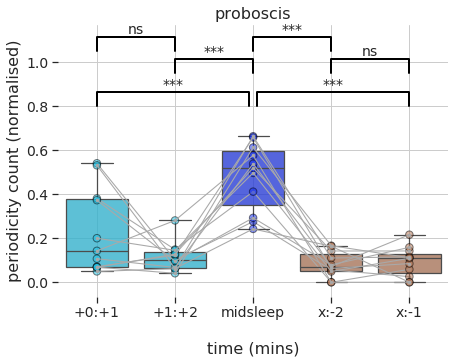

In [62]:
f, (ax1) = plt.subplots(ncols=1, figsize=(7*1, 5))

sns.boxplot(x='epochtype', y='probcnt', data=plotprobstats_df,  
            order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
            whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette=color_dict)

sns.stripplot(x='epochtype', y='probcnt', data=plotprobstats_df,
              jitter=False, linewidth=1,ax=ax1,
              order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
              palette=color_dict,marker='o', s= 7.5, alpha = 0.5,edgecolor ="black")

ax1 = sns.pointplot(x='epochtype', y='probcnt',hue='flyname',data=plotprobstats_df,
                    order=['+0:+1', '+1:+2', 'midsleep', 'x:-2', 'x:-1'],
                    ax=ax1, dodge=0.0,
                    palette=['darkgray'])

ax1.legend_.remove()
b = list(ax1.get_children())

string_val1 = 'ns'
string_val2 = '***'

statannotation(ax = ax1, x1 = 0, x2 = 1, y = 1.25-0.2, h = 0.125/2, text = string_val1)
statannotation(ax = ax1, x1 = 1, x2 = 2, y = 1.15-0.2, h = 0.125/2, text = string_val2)
statannotation(ax = ax1, x1 = 0, x2 = 1.95, y = 1.25-0.45, h = 0.125/2, text = string_val2)

statannotation(ax = ax1, x1 = 2, x2 = 3, y = 1.25-0.2, h = 0.125/2, text = string_val2)
statannotation(ax = ax1, x1 = 3, x2 = 4, y = 1.15-0.2, h = 0.125/2, text = string_val1)
statannotation(ax = ax1, x1 = 2.05, x2 = 4, y = 1.25-0.45, h = 0.125/2, text = string_val2)


for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
    
sns.despine(left=True, bottom = True)

ax1.set_ylabel('periodicity count (normalised)', fontsize=label_fontsize)
ax1.set_xlabel('\ntime (mins)', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)
ax1.set_title('proboscis',fontsize=label_fontsize)

# plt.savefig(outputfolderpath + 'microbehaviors_proboscis.svg', format='svg', dpi=240, transparent=False,
#             bbox_inches='tight')